<h1> Handwritten Character ConvNet <h1>
<p> The aim of this CNN is to correctly identify handwritten numbers and letters to be used in an OCR. This project uses primarily Python, PyTorch, Pandas, and NumPy. This Jupyter notebook was ran using Google Colab to utilise CUDA.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

import helper
import pandas as pd
import numpy as np

We will use the extended version of the EMNIST dataset to train our CNN on. The required files are located on my github: 
Note that to run this on your own, the file path must be changed.

In [ ]:
mapping_dir = "/content/drive/MyDrive/ML Data/OCR_EMNIST/emnist-balanced-mapping.txt"
cfile = open(mapping_dir, "r")

mapping = []

for line in cfile:
  values = line.split()
  mapping.append(chr(int(values[1])))

print(mapping)
print(len(mapping))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
47


To use a csv file with PyTorch's dataloader, we need to create our own Dataset class. There are no transformations needed as the EMNIST dataset has already handled that. We will have two dataloaders: test and train.

In [ ]:
train_dir = "/content/drive/MyDrive/ML Data/OCR_EMNIST/emnist-balanced-train.csv"
test_dir = "/content/drive/MyDrive/ML Data/OCR_EMNIST/emnist-balanced-test.csv"

class MyDataset(Dataset):
  def __init__(self, root, transform = None):
    self.data = pd.read_csv(root)
    self.transform = transform
    
  def __getitem__(self, idx):
    image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((1, 28, 28))
    image[0,:] = image[0,:].transpose()
    label = self.data.iloc[idx, 0]
    if self.transform:
      image = self.transform(image)
    return image, label

  def __len__(self):
    return len(self.data)

train_dataset = MyDataset(train_dir)
test_dataset = MyDataset(test_dir)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Below is an example of a training image from the EMNIST dataset

Label: C
torch.Size([64, 1, 28, 28])


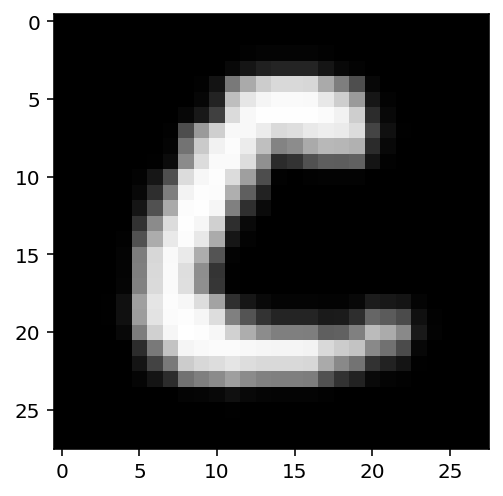

In [ ]:
images, labels = next(iter(trainloader))
plt.imshow(torch.squeeze(images[0]).numpy(), cmap='gray')
print(f"Label: {mapping[labels[0].item()]}")
print(images.shape)

The CNN structure that we use consists of a small model with three convolutional layers.

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.fc1 = nn.Linear(4 * 4 * 128, 256)
    self.fc2 = nn.Linear(256, 47)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu((self.conv1(x))))
    x = self.pool(F.relu((self.conv2(x))))
    x = self.pool(F.relu((self.conv3(x))))

    x = x.view(-1, 4 * 4 * 128)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=47, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  model.cuda()
  print("Training on GPU")
else:
  print("Training on CPU")

Training on GPU


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

The training of the model takes place here. You can change the parameters like the number of epochs or the learning rate to try to achieve a higher accuracy rating. The default is 10 epochs and a learning rate of 0.001.

In [ ]:
n_epochs = 10

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()
  for data, target in trainloader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data.float())
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  model.eval()
  with torch.no_grad():
    for data, target in testloader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      output = model(data.float())
      loss = criterion(output, target)
      valid_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    valid_loss = valid_loss / len(testloader)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_params.pt')
      valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.090557 	Validation Loss: 0.466180
Validation loss decreased (inf --> 0.466180).  Saving model ...
Epoch: 2 	Training Loss: 0.480160 	Validation Loss: 0.436697
Validation loss decreased (0.466180 --> 0.436697).  Saving model ...
Epoch: 3 	Training Loss: 0.435584 	Validation Loss: 0.392554
Validation loss decreased (0.436697 --> 0.392554).  Saving model ...
Epoch: 4 	Training Loss: 0.416985 	Validation Loss: 0.390054
Validation loss decreased (0.392554 --> 0.390054).  Saving model ...
Epoch: 5 	Training Loss: 0.401744 	Validation Loss: 0.379415
Validation loss decreased (0.390054 --> 0.379415).  Saving model ...
Epoch: 6 	Training Loss: 0.396717 	Validation Loss: 0.402101
Epoch: 7 	Training Loss: 0.388433 	Validation Loss: 0.374881
Validation loss decreased (0.379415 --> 0.374881).  Saving model ...
Epoch: 8 	Training Loss: 0.384672 	Validation Loss: 0.376633
Epoch: 9 	Training Loss: 0.381389 	Validation Loss: 0.402906
Epoch: 10 	Training Loss: 0.381725 	Valida

The model parameters will be saved as a file named "model_pararms.pt"

In [ ]:
model.load_state_dict(torch.load('model_params.pt'))

<All keys matched successfully>

The used CNN model has an overall test accuracy of 87.69%.

In [ ]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
  for data, target in testloader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    logps = model(data.float())
    ps = torch.softmax(logps, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {100 * accuracy/len(testloader):.3f}%")

Test accuracy: 87.686%


This code allows you test the model and predict the labels of character images. As you can see, the model makes reasonable mistakes that humans would commonly make like mistaking the number 5 for S or the number 0 for O. To achieve an even better model, more layers could be added or transfer learning could be used instead too.

Prediction: 0
Label: O


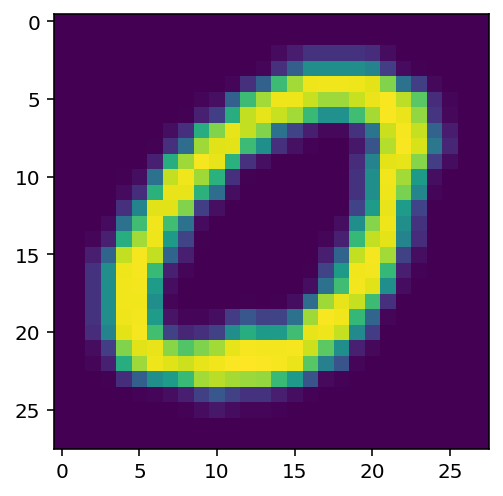

In [ ]:
data, target = iter(testloader).next()
model.to("cpu")

with torch.no_grad():
  prob = model(data.float())
  ps = torch.softmax(prob, dim=1)
  top_p, top_class = ps.topk(1, dim=1)

print("Prediction: " + str(mapping[int(top_class[0])]))
print("Label: " + str(mapping[int(target[0])]))
plt.imshow(torch.squeeze(data[0]).numpy())